<a href="https://colab.research.google.com/github/chibykelaw/Hamoye_capstone_project_smote/blob/main/efficientnetv2b1_f1score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [3]:
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow.keras.preprocessing import image_dataset_from_directory

# for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Define file paths

! git clone https://github.com/chibykelaw/Hamoye_capstone_project_smote.git
train_path = 'Hamoye_capstone_project_smote/Data/train/'
val_path = 'Hamoye_capstone_project_smote/Data/val/'
test_path = 'Hamoye_capstone_project_smote/Data/test/'

Cloning into 'Hamoye_capstone_project_smote'...
remote: Enumerating objects: 10791, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 10791 (delta 3), reused 22 (delta 3), pack-reused 10768
Receiving objects: 100% (10791/10791), 359.96 MiB | 12.18 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (10809/10809), done.


In [11]:
#Load training, validation, and test datasets from directories

train_ds = image_dataset_from_directory(train_path,label_mode='categorical',
                                        image_size=(240, 240))
val_ds = image_dataset_from_directory(val_path,label_mode='categorical',
                                      image_size=(240, 240))
test_ds = image_dataset_from_directory(test_path,label_mode='categorical',
                                       shuffle=False,image_size=(240, 240))

Found 7556 files belonging to 4 classes.
Found 2160 files belonging to 4 classes.
Found 1084 files belonging to 4 classes.


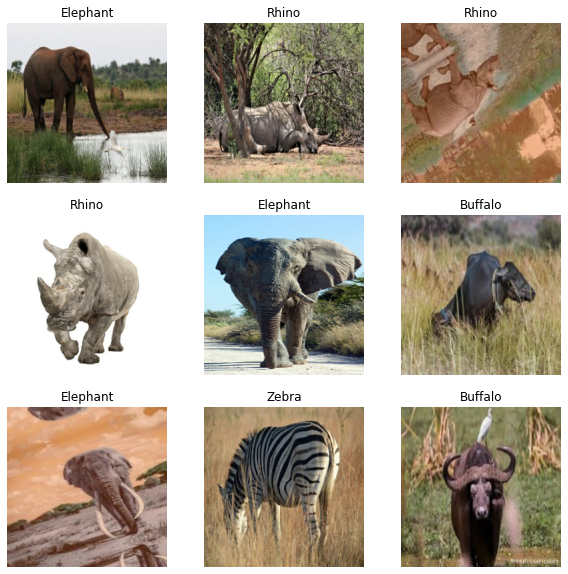

In [12]:
# View dataset

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
    plt.axis("off")

(-0.5, 239.5, 239.5, -0.5)

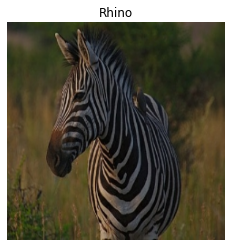

In [18]:
for images, labels in train_ds.take(1):
    first_image = images[0]

plt.imshow(first_image.numpy().astype("uint8"))
plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
plt.axis("off")


In [20]:
# make prediction with a pretrained model

from keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.applications.efficientnet_v2 import decode_predictions
from tensorflow.keras.preprocessing import image

x = image.img_to_array(first_image)
x = np.expand_dims(x, axis=0)

base_model = EfficientNetV2B1(weights='imagenet')
pred = base_model.predict(x)
print('Predicted:', decode_predictions(pred))

Predicted: [[('n02391049', 'zebra', 0.93268675), ('n02422106', 'hartebeest', 0.0029963043), ('n01798484', 'prairie_chicken', 0.00092082896), ('n02117135', 'hyena', 0.0006864138), ('n02422699', 'impala', 0.0005920559)]]


In [21]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = EfficientNetV2B1(weights='imagenet', include_top=False,
                            input_shape=(240,240,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

28467200/28456008 [==============================] - 0s 0us/step


In [23]:
# create callback for training
my_callbacks = tf.keras.callbacks.ModelCheckpoint('weights.h5',save_best_only=True,
                                                    save_weights_only=True)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_ds,epochs=10,validation_data=val_ds,
                    callbacks=[my_callbacks])

Epoch 1/10
237/237 [==============================] - 774s 3s/step - loss: 0.0153 - accuracy: 0.9959 - val_loss: 0.0146 - val_accuracy: 0.9968
Epoch 2/10
237/237 [==============================] - 825s 3s/step - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.0126 - val_accuracy: 0.9963
Epoch 3/10
237/237 [==============================] - 799s 3s/step - loss: 0.0076 - accuracy: 0.9984 - val_loss: 0.0114 - val_accuracy: 0.9963
Epoch 4/10
237/237 [==============================] - 786s 3s/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.0107 - val_accuracy: 0.9963
Epoch 5/10
237/237 [==============================] - 767s 3s/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 0.0105 - val_accuracy: 0.9963
Epoch 6/10
237/237 [==============================] - 782s 3s/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.0099 - val_accuracy: 0.9972
Epoch 7/10
237/237 [==============================] - 808s 3s/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0097 - val_accuracy: 0.9972

In [24]:
# save results
results = history.history

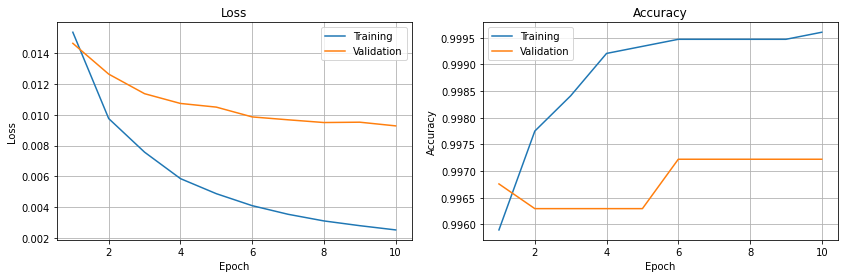

In [25]:
# plot results

n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])
plt.grid(True)
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
model.load_weights('weights.h5')

In [27]:
predictions = model.evaluate(test_ds)

34/34 [==============================] - 84s 2s/step - loss: 0.0139 - accuracy: 0.9945


In [28]:
# make predictions on the unseen data

predictions = model.predict(test_ds)
predictions

array([[9.9990475e-01, 5.9912315e-07, 9.2930655e-05, 1.6609885e-06],
       [9.9995279e-01, 4.0969576e-07, 4.6004207e-05, 8.0813146e-07],
       [9.9760914e-01, 3.9661671e-07, 2.3889462e-03, 1.5413344e-06],
       ...,
       [5.7762159e-06, 6.0427224e-06, 5.7603421e-07, 9.9998760e-01],
       [3.4089751e-06, 1.2261502e-06, 4.4196646e-08, 9.9999535e-01],
       [3.6283570e-08, 1.2436969e-07, 5.5648384e-09, 9.9999988e-01]],
      dtype=float32)

In [29]:
# save the index of the highest probability

predictions = predictions.argmax(axis=1)
predictions

array([0, 0, 0, ..., 3, 3, 3])

In [30]:
# get the actual values

test_images = list(test_ds.unbatch().as_numpy_iterator())
y_true = np.array([i[1] for i in test_images])
y_true = y_true.argmax(axis=1)
y_true

array([0, 0, 0, ..., 3, 3, 3])

In [31]:
# calculate f1_score

from sklearn.metrics import f1_score
f1_score(y_true,predictions,average='macro')

0.9944733984544118

In [32]:
# get the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,predictions)

array([[269,   0,   2,   0],
       [  2, 269,   0,   0],
       [  1,   0, 270,   0],
       [  1,   0,   0, 270]])

In [34]:
import pandas as pd
comparison = pd.DataFrame({'actual':y_true,'predicted':predictions,
                           'same':y_true==predictions})
comparison.replace({0:'Buffalo',1:'Elephant',2:'Rhino',3:'Zebra'},inplace=True)
comparison[comparison.same==True]

,actual,predicted,same
0,Buffalo,Buffalo,True
1,Buffalo,Buffalo,True
2,Buffalo,Buffalo,True
3,Buffalo,Buffalo,True
4,Buffalo,Buffalo,True
...,...,...,...
1079,Zebra,Zebra,True
1080,Zebra,Zebra,True
1081,Zebra,Zebra,True
1082,Zebra,Zebra,True


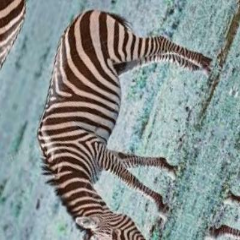

In [35]:
image.array_to_img(test_images[1083][0])

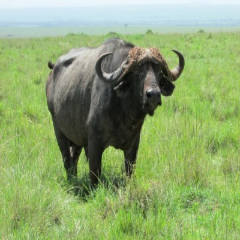

In [38]:
image.array_to_img(test_images[0][0])

In [39]:
# Incorrect prediction

comparison = pd.DataFrame({'actual':y_true,'predicted':predictions,
                           'same':y_true==predictions})
comparison.replace({0:'Buffalo',1:'Elephant',2:'Rhino',3:'Zebra'},inplace=True)
comparison[comparison.same==False]

,actual,predicted,same
138,Buffalo,Rhino,False
258,Buffalo,Rhino,False
287,Elephant,Buffalo,False
295,Elephant,Buffalo,False
749,Rhino,Buffalo,False
813,Zebra,Buffalo,False


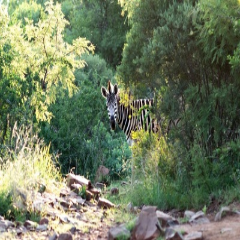

In [40]:
image.array_to_img(test_images[813][0])

In [41]:
# Save the model as .pkl

import pickle
pickle.dump(model, open('EfficientNetV2B1.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://1b3f2288-a927-4b01-9e1e-efda73b86e78/assets
